In [10]:
# We need to install this library to get our satellite data easily
!pip install tensorflow_datasets

# Now we import our "toolkits"
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import numpy as np

In [11]:
# Set our standards
IMG_SIZE = (224, 224)
BATCH_SIZE = 32

# Define a function to resize and normalize images
def preprocess(image, label):
    image = tf.image.resize(image, IMG_SIZE)
    image = tf.cast(image, tf.float32) / 255.0  # Scale pixel values to 0-1
    return image, label

# Load the dataset using efficient splits
# This tells tfds to only load the slices we need, one by one.
(ds_train, ds_val, ds_test), ds_info = tfds.load(
    'eurosat/rgb',
    # This is the magic part: it streams the splits directly.
    split=['train[:80%]', 'train[80%:90%]', 'train[90%:]'],
    shuffle_files=True,
    as_supervised=True, # Returns (image, label) pairs
    with_info=True
)

# Get the human-readable names for the categories (like 'Forest')
CLASS_NAMES = ds_info.features['label'].names
print("Categories:", CLASS_NAMES)

# Create the final data pipelines
# We apply the preprocessing, batching, and prefetching
ds_train = ds_train.map(preprocess, num_parallel_calls=tf.data.AUTOTUNE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
ds_val = ds_val.map(preprocess, num_parallel_calls=tf.data.AUTOTUNE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
ds_test = ds_test.map(preprocess, num_parallel_calls=tf.data.AUTOTUNE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

print("Data pipelines created successfully.")

Categories: ['AnnualCrop', 'Forest', 'HerbaceousVegetation', 'Highway', 'Industrial', 'Pasture', 'PermanentCrop', 'Residential', 'River', 'SeaLake']
Data pipelines created successfully.


In [12]:
# 1. Get the pre-trained "engine" (MobileNetV2)
# We don't include its original 'top' layer
base_model = tf.keras.applications.MobileNetV2(
    input_shape=IMG_SIZE + (3,), # (224, 224, 3-color-channels)
    include_top=False,
    weights='imagenet' # Load weights pre-trained on 1.4 million images
)

# 2. Freeze the "engine"
# We don't want to change the parts that are already expert at seeing
base_model.trainable = False

# 3. Build our new model by stacking our new parts on top
model = tf.keras.Sequential([
    base_model,  # The frozen expert engine
    tf.keras.layers.GlobalAveragePooling2D(), # A layer to simplify the output
    tf.keras.layers.Dropout(0.2), # Helps prevent the model from 'cheating'
    tf.keras.layers.Dense(len(CLASS_NAMES), activation='softmax') # The final decision layer
                                                                # 'softmax' makes it pick one category
])

# 4. "Compile" the model (put all the pieces together)
model.compile(
    optimizer='adam', # The 'adam' optimizer is a good, fast default
    loss='sparse_categorical_crossentropy', # This measures how 'wrong' the model is
    metrics=['accuracy'] # We want to track its accuracy
)

# Print a summary of our model
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │        12,810 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,270,794 (8.66 MB)

 Trainable params: 12,810 (50.04 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [13]:
# This step will take 5-10 minutes. Watch the 'val_accuracy' go up!
print("Starting training...")
history = model.fit(
    ds_train,
    epochs=10,
    validation_data=ds_val
)
print("Training finished!")

Starting training...
Epoch 1/10
675/675 ━━━━━━━━━━━━━━━━━━━━ 49s 54ms/step - accuracy: 0.7669 - loss: 0.7032 - val_accuracy: 0.9059 - val_loss: 0.2706
Epoch 2/10
675/675 ━━━━━━━━━━━━━━━━━━━━ 22s 33ms/step - accuracy: 0.8986 - loss: 0.2948 - val_accuracy: 0.9174 - val_loss: 0.2447
Epoch 3/10
675/675 ━━━━━━━━━━━━━━━━━━━━ 22s 33ms/step - accuracy: 0.9087 - loss: 0.2596 - val_accuracy: 0.9185 - val_loss: 0.2325
Epoch 4/10
675/675 ━━━━━━━━━━━━━━━━━━━━ 23s 34ms/step - accuracy: 0.9152 - loss: 0.2386 - val_accuracy: 0.9211 - val_loss: 0.2301
Epoch 5/10
675/675 ━━━━━━━━━━━━━━━━━━━━ 22s 32ms/step - accuracy: 0.9205 - loss: 0.2271 - val_accuracy: 0.9259 - val_loss: 0.2212
Epoch 6/10
675/675 ━━━━━━━━━━━━━━━━━━━━ 22s 33ms/step - accuracy: 0.9260 - loss: 0.2180 - val_accuracy: 0.9185 - val_loss: 0.2302
Epoch 7/10
675/675 ━━━━━━━━━━━━━━━━━━━━ 22s 33ms/step - accuracy: 0.9257 - loss: 0.2074 - val_accuracy: 0.9252 - val_loss: 0.2152
Epoch 8/10
675/675 ━━━━━━━━━━━━━━━━━━━━ 22s 33ms/step - accuracy: 0.9

In [14]:
# Evaluate the model on the test data
loss, accuracy = model.evaluate(ds_test)

print(f"Final Test Accuracy: {accuracy * 100:.2f}%")

85/85 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - accuracy: 0.9248 - loss: 0.2069
Final Test Accuracy: 92.11%


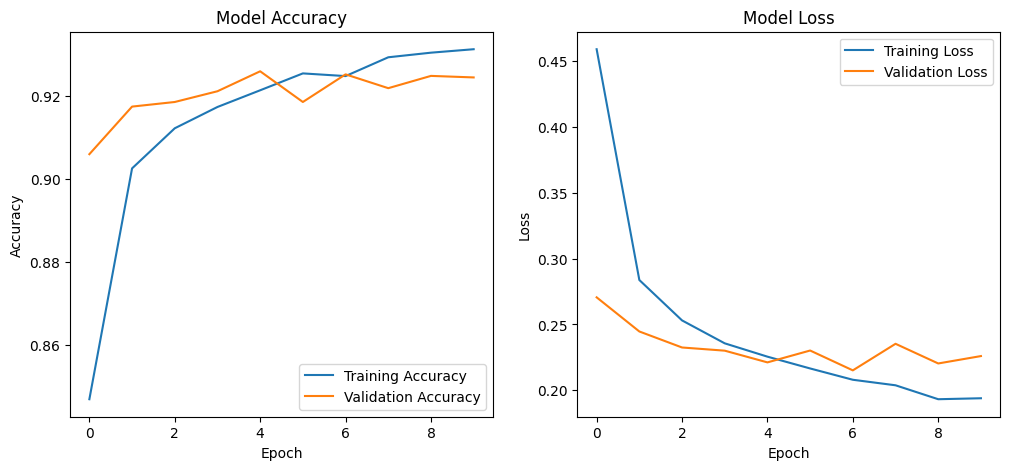

In [15]:
# Create a figure with two plots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# --- Plot Accuracy ---
ax1.plot(history.history['accuracy'], label='Training Accuracy')
ax1.plot(history.history['val_accuracy'], label='Validation Accuracy')
ax1.set_title('Model Accuracy')
ax1.set_ylabel('Accuracy')
ax1.set_xlabel('Epoch')
ax1.legend()

# --- Plot Loss ---
ax2.plot(history.history['loss'], label='Training Loss')
ax2.plot(history.history['val_loss'], label='Validation Loss')
ax2.set_title('Model Loss')
ax2.set_ylabel('Loss')
ax2.set_xlabel('Epoch')
ax2.legend()

plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step


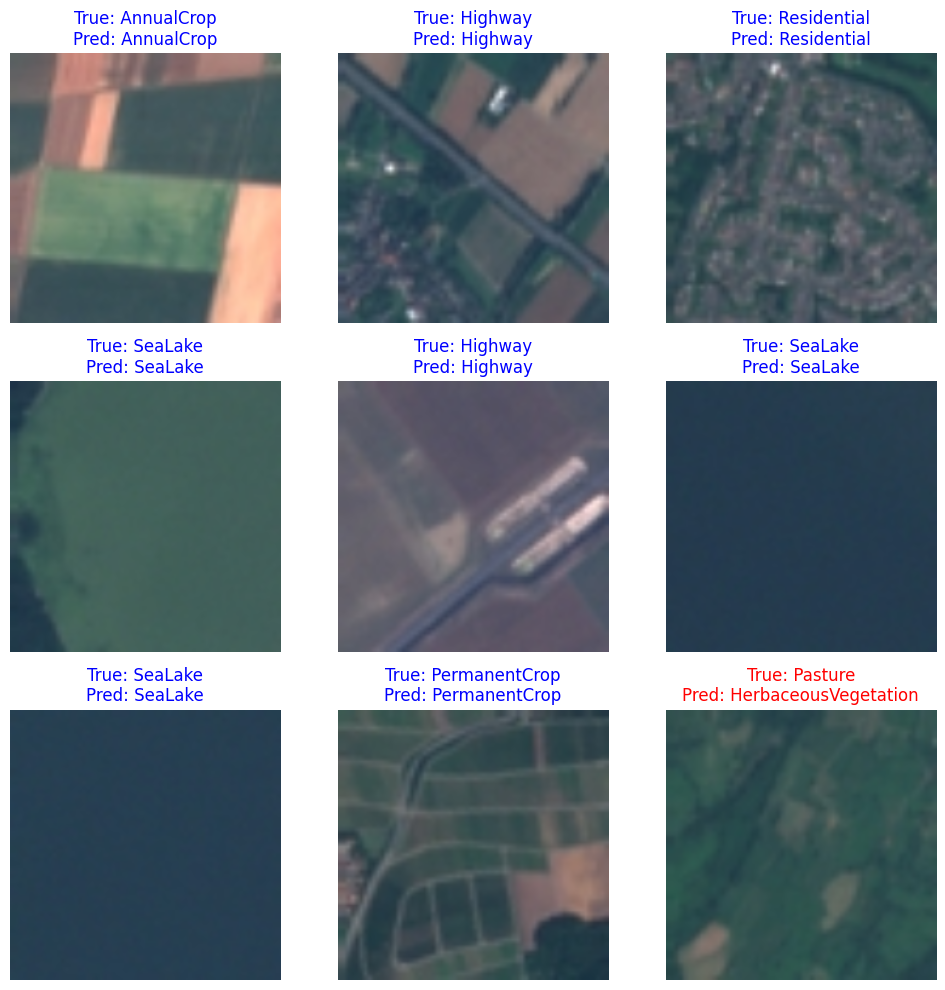

In [16]:
import numpy as np

# 1. Get one batch of images and labels from the test set
for images, labels in ds_test.take(1):
    # 2. Get the model's predictions
    predictions = model.predict(images)

    # 3. Show the first 9 images and their labels
    plt.figure(figsize=(10, 10))
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i])

        # The 'predictions' are arrays of 10 probabilities.
        # We find the index of the highest probability.
        predicted_class_index = np.argmax(predictions[i])
        predicted_class_name = CLASS_NAMES[predicted_class_index]

        # Get the true class name
        true_class_name = CLASS_NAMES[labels[i]]

        # Set the title color
        if predicted_class_name == true_class_name:
            title_color = 'blue'
        else:
            title_color = 'red'

        plt.title(f"True: {true_class_name}\nPred: {predicted_class_name}", color=title_color)
        plt.axis("off")

plt.tight_layout()
plt.show()

In [17]:
# Save the entire model to a single file.
# The .keras format is the new standard and saves everything.
model.save('my_land_use_model.keras')

print("Model saved to my_land_use_model.keras")

Model saved to my_land_use_model.keras
